In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf  # Statsmodels is a Python module for statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data   # A package prepared for the book, especially to use in the labs 
from ISLP.models import (ModelSpec as MS, summarize , poly) #it has built in functions and methods adopted 
                                                            # from various common python ML libraries 
                                                            # to help build and validate models 

## 3.6.2 Simple Linear Regression

In [3]:
df = load_data('Boston')

df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [4]:
print(f'Boston housing data contains {df.shape[0]} entries with a total of {df.shape[1]} columns')
print('\n')
print(f'It has records of median house values (medv) for {df.shape[0]} neighborhoods in Boston')
print('\n')
print(f'We will build a model to predict medv using the remaining {df.shape[1]-1} predictors')

Boston housing data contains 506 entries with a total of 13 columns


It has records of median house values (medv) for 506 neighborhoods in Boston


We will build a model to predict medv using the remaining 12 predictors


In [ ]:
# rm: average number of rooms per house
# age: proportion of owner occupied units built prior to 1940
# lstat: precent of households with low socioeconomic status

 - We start with a simple regression model to investigate the lstat - medv relation

In [5]:
X = pd.DataFrame({'intercept': np.ones(df.shape[0]), 'lstat': df['lstat']}) # Training matrix with a specified
                                                                            # initial intercept

y = df['medv'] # response 

X[:5]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [6]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary()) # get the full report of the fit results

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           5.08e-88
Time:                        14:18:42   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.0

In [21]:
summarize(results) # Built in summarize method returns a summarized version of the report above

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [7]:
# Shortcuts to design models using MS in ISLP library

design = MS(['lstat'])

Xa = design.fit_transform(df) # fit + transform = fit could normally do more complext operations on the data
                             # such as computing means, standard deviations for centering and scaling etc. 
                             # transform method applies the fitted transformation to the array of data
                             # to produce the model matrix
                             # In our case fit() does not do much, just checks if 'lstat' in the df
                
Xa[:5]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [8]:
# params attribute can be used to get fitted coefficients 

results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

In [9]:
# get_prediction() method can be used to obtain predictions, and produce confidence intervals and prediction
# intervals 

In [12]:
pred_df = pd.DataFrame({'lstat': [5, 10, 15]})

pred_X = design.transform(pred_df)

pred_X

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [13]:
predictions = results.get_prediction(pred_X)

predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [14]:
# 95 % confidence and prediction intervals for the predicted values

predictions.conf_int(alpha = 0.05), predictions.conf_int(obs = True, alpha = 0.05),

(array([[29.00741194, 30.59977628],
        [24.47413202, 25.63256267],
        [19.73158815, 20.87461299]]),
 array([[17.56567478, 42.04151344],
        [12.82762635, 37.27906833],
        [ 8.0777421 , 32.52845905]]))

In [15]:
# Adding a regression line to a plot, b in intercept, s is slope

def LinRegLine(ax, b, s, *args, **kwargs):
    
    xlim = ax.get_xlim()
    
    ylim = [b + s * xlim[0], b + s * xlim[1]]
    
    ax.plot(xlim, ylim, *args, **kwargs)

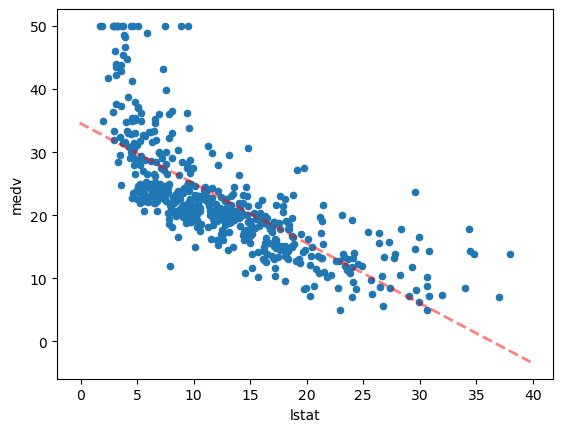

In [16]:
axis = df.plot.scatter('lstat', 'medv')

LinRegLine(axis, results.params[0], results.params[1], '--r', linewidth = 2, alpha = 0.5)

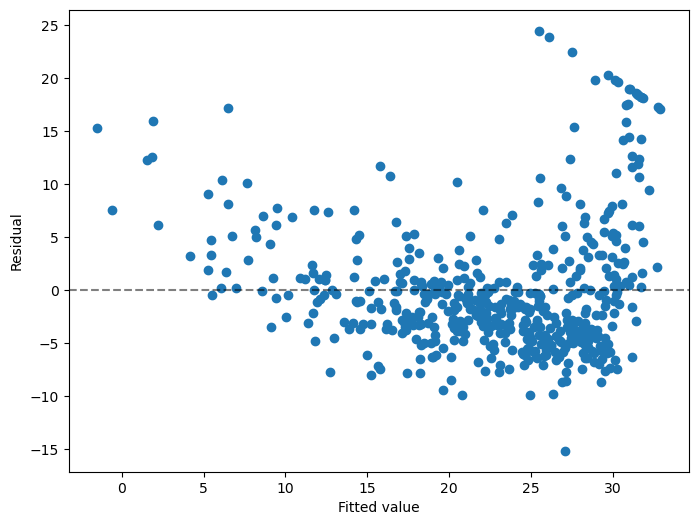

In [17]:
# Residual plots 

ax = plt.subplots(figsize = (8,6))[1]

ax.scatter(results.fittedvalues, results.resid)

ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')

ax.axhline(0, color = 'black', linestyle = 'dashed', alpha = 0.5)

In [ ]:
# Some non-linearity is present! 

In [ ]:
# Leverage statistics is computed for any number of predictors using hat_matrix_diag attribute of the value
# returned by the get_influence method

In [44]:
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


Text(0, 0.5, 'Leverage')

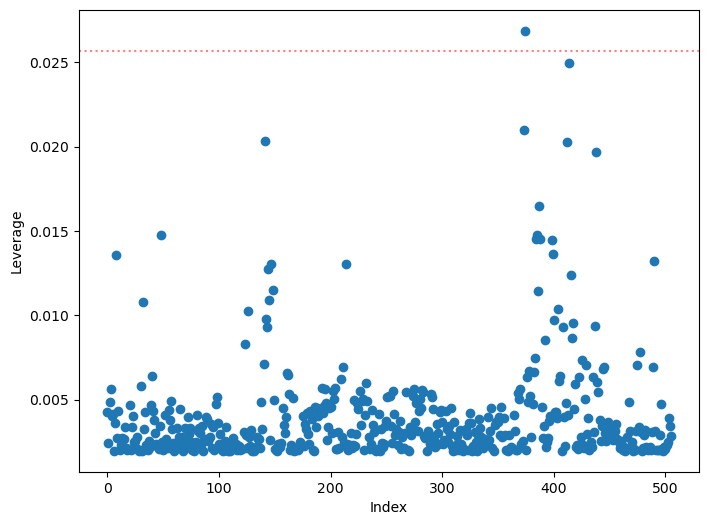

In [18]:
infl = results.get_influence()

ax = plt.subplots(figsize = (8,6))[1]

ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)

ax.axhline(((df.shape[1]-1) + 1)/df.shape[0], alpha = 0.5, color = 'red', linestyle = 'dotted') 
# Average leverage using 12 features
 
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')

In [19]:
print(f'The index of the observation with the highest leverate is {np.argmax(infl.hat_matrix_diag)}')

The index of the observation with the highest leverate is 374


## 3.6.3 Multiple Linear Regression

In [20]:
# Lets try a model with one more feature first 

X = MS(['lstat', 'age']).fit_transform(df)

model1 = sm.OLS(y,X)

results1 = model1.fit()

print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           2.98e-88
Time:                        14:20:37   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     33.2228      0.731     45.458      0.0

In [21]:
predictors = df.columns.drop('medv') # Take all the features except the target from the df and specify the model
                                     # and fit 
    
X = MS(predictors).fit_transform(df)

MLRmodel = sm.OLS(y, X)

MLR_results = MLRmodel.fit()

print(MLR_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          2.23e-133
Time:                        14:20:44   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.6173      4.936      8.431      0.0

In [22]:
# Lets drop age which has a large p value and build an alternate model 

predictorsm_age = df.columns.drop(['medv','age'])

Xma = MS(predictorsm_age).fit_transform(df)

modela = sm.OLS(y, Xma)

print(modela.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     124.1
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          2.03e-134
Time:                        14:21:00   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3034.
Df Residuals:                     494   BIC:                             3085.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.5251      4.920      8.441      0.0

## 3.6.4 Multivariate Goodness of Fit

In [58]:
# To see possible methods one can use with MLR_results

# dir(MLR_results)

In [23]:
MLR_R2 = MLR_results.rsquared # R^2 score of the original Multiple LR model

MLR_RSE = np.sqrt(MLR_results.scale)

print(f'R^2 and Residual standard Error of the Multiple LR model are {MLR_R2} and {MLR_RSE}' )

R^2 and Residual standard Error of the Multiple LR model are 0.7343070437613076 and 4.798034335596367


In [24]:
X[predictors]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48


In [25]:
X

,intercept,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67
502,1.0,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08
503,1.0,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64
504,1.0,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48


In [26]:
# Variance Inflation factor to detect multicollinearity 

# VIF function we define takes two arguments and DF or Array and column/feature index 

# The lab uses the X matrix which also include the dummy intercept with 1's 

X

,intercept,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67
502,1.0,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08
503,1.0,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64
504,1.0,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48


In [27]:
X[predictors]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48


In [29]:
VIF_valsa = [VIF(X[predictors],i) for i in range(X[predictors].shape[1])]

vif_dfa = pd.DataFrame({'VIF': VIF_valsa}, index = X[predictors].columns)

vif_dfa

,VIF
crim,2.077944
zn,2.842980
indus,14.446693
chas,1.148528
nox,73.077558
rm,76.160431
age,21.350797
dis,14.576652
rad,14.732498
tax,61.225416


In [30]:
# Results using X (and ignoring intercept) is different than when we use X[predictors]
# I expect them to be the same, what is happening here?

## 3.6.5 Interaction terms

In [31]:
# We can add interaction features in a model using tuples in the Model Specifier MS

X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(df)

model_int = sm.OLS(y,X)

print(model_int.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           4.86e-88
Time:                        14:23:19   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     36.0885      1.470     24.553      0.0

## Non-linear transformations of the predictors 

In [34]:
X = MS([poly('lstat', degree = 2), 'age']).fit_transform(df)

model3 = sm.OLS(y,X)

results3 = model3.fit()

print(results3.summary())


                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     337.3
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          7.03e-120
Time:                        14:32:44   Log-Likelihood:                -1561.0
No. Observations:                 506   AIC:                             3130.
Df Residuals:                     502   BIC:                             3147.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept               

In [35]:
# Use anova_lm to quantify the extent of which the quadratic model is better than the baseline linear fit 
# It performs a hypothesis test comparing two models, the null hypothesis is set by the first argument model
# i.e quadratic terms is not needed, alternative hypothesis is that the bigger model is superior. 

anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


In [ ]:
# It can take more than 2 nested models as an argument in which case it compares every successive models
# which explains 'NaN' values in the first row below

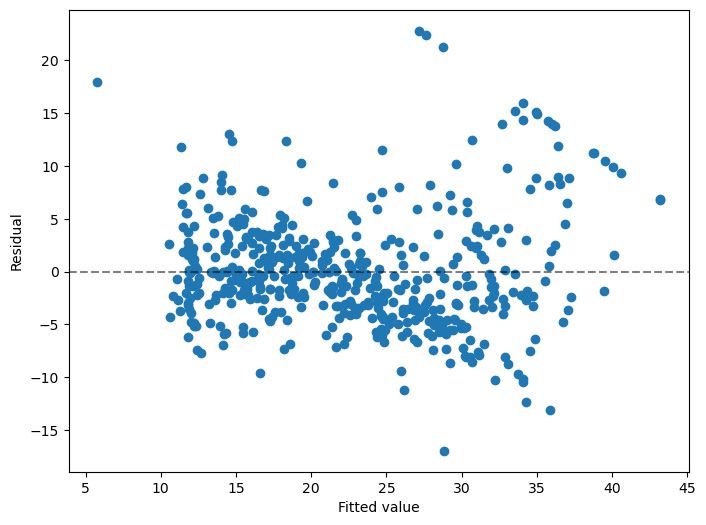

In [36]:
# Check residuals with the non-linear model 

ax = plt.subplots(figsize = (8,6))[1]

ax.scatter(results3.fittedvalues, results3.resid)

ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')

ax.axhline(0, color = 'black', linestyle = 'dashed', alpha = 0.5)

In [ ]:
# There is a little discernable pattern in the residuals but it looks better than the linear model 